In [1]:
import random
from collections import namedtuple, deque

import gym
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_seed(seed=22):
    random.seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
env = gym.make("CartPole-v0")
print(env.env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gra

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
class DQN(nn.Module):
    def __init__(self, state_size, act_size, hidden_size):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(),
        )
        
        self.head = nn.Linear(hidden_size, act_size)
        
    def forward(self, state):
        return self.head(self.layer2(self.layer1(state)))

In [7]:
transition = namedtuple("transition", field_names=["state", "action", "reward", "next_state", "done"])

In [8]:
class Agent:
    def __init__(self, input_dim, output_dim, hidden_dim, gamma=0.99, capacity=50000):
        self.dqn = DQN(input_dim, output_dim, hidden_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gamma = gamma
        self.traj_history = deque(maxlen=capacity)

        self.loss_fn = nn.MSELoss()
        self.optim = Adam(self.dqn.parameters())
    
    def _to_variable(self, x):
        return Variable(torch.Tensor(x))
    
    def get_Q(self, states):
        states = self._to_variable(states.reshape(-1, self.input_dim))
        self.dqn.train(mode=False)
        return self.dqn(states)
    
    def get_action(self, states, eps):
        if np.random.rand() < eps:
            return np.random.choice(self.output_dim)
        else:
            self.dqn.train(mode=False)
            scores = self.get_Q(states)
            _, argmax = torch.max(scores.data, 1)
            return int(argmax.numpy())
        
    def train(self, Q_pred, Q_true):
        self.dqn.train()
        self.optim.zero_grad()
        loss = self.loss_fn(Q_pred, Q_true)
        loss.backward()
        self.optim.step()
        return loss

In [9]:
def train_helper(agent, minibatch, gamma):
    states = np.vstack([x.state for x in minibatch])
    actions = np.array([x.action for x in minibatch])
    rewards = np.array([x.reward for x in minibatch])
    next_states = np.vstack([x.next_state for x in minibatch])
    done = np.array([x.done for x in minibatch])
    
    Q_predict = agent.get_Q(states)
    Q_target = Q_predict.clone().data.numpy()
    Q_target[np.arange(len(Q_target)), actions] = rewards + gamma * np.max(agent.get_Q(next_states).data.numpy(), axis=1) * ~done
    Q_target = agent._to_variable(Q_target)

    return agent.train(Q_predict, Q_target)

In [10]:
def play_episode(env, agent, eps, batch_size):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.get_action(state, eps)
        new_state, reward, done, info = env.step(action)
        
        total_reward += reward
        
        if done:
            reward = -1
            
        agent.traj_history.append(
            transition(state=state, action=action, reward=reward, next_state=new_state, done=done)
        )
        if len(agent.traj_history) > batch_size:
            minibatch = random.sample(agent.traj_history, batch_size)
            train_helper(agent, minibatch, agent.gamma)

        state = new_state

    return total_reward

In [11]:
def get_env_dim(env):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    return input_dim, output_dim

In [12]:
def epsilon_annealing(epsiode, max_episode, min_eps):
    slope = (min_eps - 1.0) / max_episode
    return max(slope * epsiode + 1.0, min_eps)

In [13]:
def main():
    set_seed()
    rewards_history = []
    moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values
    input_dim, output_dim = get_env_dim(env)
    agent = Agent(input_dim, output_dim, HIDDEN_DIM)
    
    for step in range(N_EPISODE):
        eps = epsilon_annealing(step, MAX_EPISODE, MIN_EPS)
        reward = play_episode(env, agent, eps, BATCH_SIZE)
        
        rewards_history.append(reward)
        
        if step % 10:
            clear_output(True)
            plt.figure(figsize=[12, 6])
            plt.title('Returns'); plt.grid()
            plt.scatter(np.arange(len(rewards_history)), rewards_history, alpha=0.1)
            plt.plot(moving_average(rewards_history, span=10, min_periods=10))
            plt.show()
        
        running_reward = np.mean(rewards_history[-20:])
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {} time steps!"\
                  .format(reward, step))
            break

In [14]:
HIDDEN_DIM = 256
MIN_EPS = 0.01
MAX_EPISODE = 20
N_EPISODE = 1000
BATCH_SIZE = 64

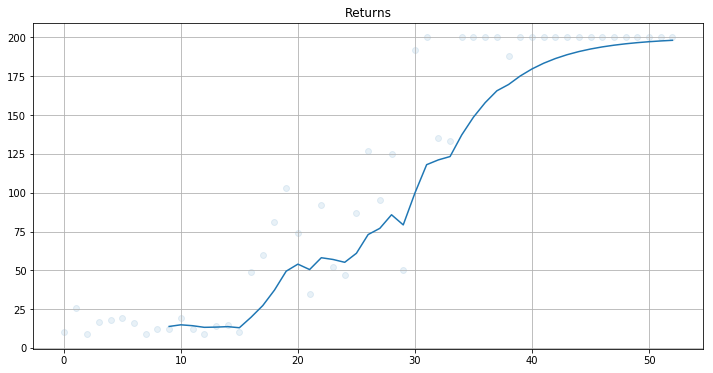

Solved! Running reward is now 200.0 and the last episode runs to 52 time steps!


In [15]:
main()